In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse.linalg as spla
from scipy import linalg
from scipy import sparse
import time

import finite
import timesteppers
import equations

## Navier Stokes

In this project we first try to solve compressible Navier Stokes equations, modeling a shear KH instability. We also try to solve incompressible Navier Stokes.

The governing equations are as follows:

$$\frac{\partial \rho}{\partial t} + u \cdot \nabla \rho = - \rho \nabla \cdot u$$

$$\frac{\partial v}{\partial t} + u \cdot \nabla u = - \frac{\nabla p}{\rho} + \frac{\mu}{\rho} (\nabla ^2 u + \frac{1}{3} \nabla(\nabla \cdot u))$$

$$\frac{\partial p}{\partial t} + u \cdot \nabla p - (\frac{\gamma p}{\rho} (\frac{\partial \rho}{\partial t} + u \cdot \nabla \rho)) = K \nabla ^2 (\frac{p}{\rho})$$


In [2]:
def plot_2D(matrix):
    lim_margin = -0.05
    fig = plt.figure(figsize=(3,3))
    ax = fig.add_subplot()
    I, J = matrix.shape
    # matrix_mag = np.log10(np.abs(matrix))
    matrix_mag = matrix
    ax.pcolor(matrix_mag[::-1])
    ax.set_xlim(-lim_margin, I+lim_margin)
    ax.set_ylim(-lim_margin, J+lim_margin)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect('equal', 'box')
    plt.tight_layout()
    plt.show()

/opt/homebrew/lib/python3.11/site-packages/scipy/sparse/_index.py:143: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


<IPython.core.display.Javascript object>


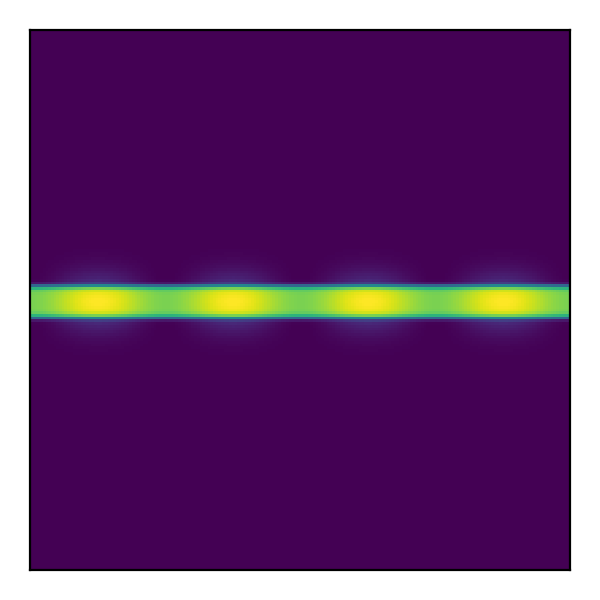

In [3]:
resolution = 200
alpha = 0.25
spatial_order = 2

# grid_x = finite.UniformNonPeriodicGrid(resolution,(0,2*np.pi))
grid_x = finite.UniformPeriodicGrid(resolution,2*np.pi)
grid_y = finite.UniformPeriodicGrid(resolution,2*np.pi)
domain = finite.Domain([grid_x, grid_y])
x, y = domain.values()

r = np.sqrt((x-10)**2 + (y-10)**2)
IC = np.exp(-r**2/4)

Z = np.zeros(domain.shape)

u = np.zeros(domain.shape)
v = np.zeros(domain.shape)
p = np.zeros(domain.shape)
nu = 0.1
mu = 1 / 5e4
kappa = 1.4
gamma = 5/3
rho = 1

r = np.sqrt((x-3*np.pi/4)**2 + (y-np.pi/2)**2)
IC = np.exp(-r**2*16)
# u[:] = IC
# u[:] = IC
# v[:] = IC
# u[100:120,:] = 0.1

radius = 0.2
# # smaller number here means faster dropoff
dropoff = 0.04
IC_vx = 1/2 * (np.tanh(((y - np.pi)-radius)/dropoff) - np.tanh(((y - np.pi)+radius)/dropoff))
u[:] = IC_vx.T
# u[:] = 1

IC_vy = .5 * np.sin(2*x) * np.exp(-((y) - np.pi)**2/0.2)
v[:] = IC_vy.T

p[:] = 0.1

# print(np.min(IC_vx))
# print(np.max(IC_vy))

# # u['g'][0, :, :128] = 1
# # u['g'][1, :, :128] = 0.1 * np.sin(2*np.pi*x/Lx)
# # Add small vertical velocity perturbations localized to the shear layers
# u['g'][1] += 0.1 * np.sin(2*np.pi*x/Lx) * np.exp(-(z)**2/0.1)
# u['g'][1] += 0.1 * np.sin(2*np.pi*x/Lx) * np.exp(-(z+0.5)**2/0.01)

# eq = equations.NavierStokes(u, v, p, mu, kappa, gamma, rho, spatial_order, domain)
diff = equations.IncompressibleNavierStokes(u, v, p, nu, spatial_order, domain)

dt = alpha*grid_y.dx

# ts = timesteppers.CNAB(eq)

# ts.evolve(dt, .01-1e-5)

# fig, ax = plt.subplots()
# ln = plt.plot(x, u, 'r-')
# plt.show()
# while diff.t < .03*np.pi/4 - 1e-5:
#     diff.step(dt)

# print(f"dt: {dt}")
# print(f"iter: {diff.iter}")

# print(u)

# plot_2D(p)
plot_2D(u * u + v * v)
plt.show()